# Handwritten Digit Recognition
## Using 5 layer Convolutional Neural Network 
### Activation function: RELU  
### Learning rate: dynamic 
### Including Dropouts for each RELU layer

In [1]:
# including helper file to use some handy functions
import os
helper_file = os.getcwd() + '\\helpers.ipynb'
%run $helper_file

# importing needed libraries
import numpy as np
import tensorflow as tf
import math

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, reshape=False, validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [4]:
# parameters
BATCH_SIZE = 100
ITERATION_COUNT = 15000
ACCURACY_CHECK = 100

In [5]:
def train(mnist_data, batch_size, iteration_count, accuracy_check):
    
    image_width  = 28
    image_height = 28
    
    C0 = 1   # input channel count
    C1 = 4 # convolutional network channel 1 count 
    C2 = 8 # convolutional network channel 2 count
    C3 = 12  # convolutional network channel 3 count
    C4 = 200  # fulley connected layer size
    C5 = 10  # output count (digit count 0 to 9)
    
    # weights
    W1 = tf.Variable(tf.truncated_normal([5, 5, C0, C1], stddev = 0.1)) 
    W2 = tf.Variable(tf.truncated_normal([5, 5, C1, C2], stddev = 0.1))
    W3 = tf.Variable(tf.truncated_normal([4, 4, C2, C3], stddev = 0.1))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * C3, C4], stddev = 0.1))
    W5 = tf.Variable(tf.truncated_normal([C4, C5], stddev = 0.1))
    
    # biases
    B1 = tf.Variable(tf.ones([C1]) / 10)
    B2 = tf.Variable(tf.ones([C2]) / 10)
    B3 = tf.Variable(tf.ones([C3]) / 10)
    B4 = tf.Variable(tf.ones([C4]) / 10)
    B5 = tf.Variable(tf.ones([C5]) / 10)

    # model
    stride = 1  # output is 28x28
    X   = tf.placeholder(tf.float32, shape=[None, image_width, image_height, C0])
    Y1  = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    stride = 2  # output is 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    stride = 2  # output is 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)
    
    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * C3])
    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    Ylogits = tf.matmul(Y4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
                      
    # paceholder for learing_rate variable
    lr = tf.placeholder(tf.float32)
    
    # placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, C5])
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y_)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    # initialisation
    init = tf.global_variables_initializer()

    # start computation
    sess = tf.Session()
    sess.run(init)
    
    # preparing return values
    counter = 0 
    upper_bound = int(iteration_count / accuracy_check)
    iterations = np.arange(0, upper_bound)
    train_accuracy = np.zeros(upper_bound)
    train_loss = np.zeros(upper_bound)
    test_accuracy = np.zeros(upper_bound)
    test_loss = np.zeros(upper_bound)
    learning_rates = np.zeros(1)
    
    for i in range(iteration_count):
        
        # learning rate decay
        max_learning_rate = 0.003
        min_learning_rate = 0.0001
        decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        # load batch of images and correct answers
        batch_X , batch_Y = mnist_data.train.next_batch(batch_size)
        
        # train
        sess.run(train_step, feed_dict = {X: batch_X, Y_: batch_Y, lr: learning_rate})
        
        if i % accuracy_check == 0:

            a , c = sess.run([accuracy, cross_entropy], feed_dict = {X: batch_X, Y_: batch_Y})
            train_accuracy[counter] = a
            train_loss[counter] = c
            
            test_data = {X: mnist_data.test.images, Y_: mnist_data.test.labels}
            pred, a , c = sess.run([Y, accuracy, cross_entropy], feed_dict = test_data)
            predictions = tf.argmax(pred,1).eval(session=sess)
            print('{}- Accuracy: {}, Learning Rate: {}'.format(i, a, learning_rate))
            test_accuracy[counter] = a
            test_loss[counter] = c
            
            counter += 1
            
    learning_rates[0] = learning_rate
    acc = accuracy.eval(session = sess, feed_dict = {X: mnist_data.test.images, Y_: mnist_data.test.labels})
    print('Learning Rate: {}, Accuracy: {}'.format(learning_rate, acc))
    sess.close()
    
    return iterations, train_accuracy, train_loss, test_accuracy, test_loss, predictions, learning_rates;

In [6]:
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []

%time acc_check, temp_train_acc, temp_train_loss, temp_test_acc, temp_test_loss, predictions, learning_rates = train(mnist, BATCH_SIZE, ITERATION_COUNT, ACCURACY_CHECK)

train_accuracy.append(temp_train_acc)
train_loss.append(temp_train_loss)
test_accuracy.append(temp_test_acc)
test_loss.append(temp_test_loss)

0- Accuracy: 0.10580000281333923, Learning Rate: 0.003
100- Accuracy: 0.9188001155853271, Learning Rate: 0.0028585653310520707
200- Accuracy: 0.9608001112937927, Learning Rate: 0.0027240285123042826
300- Accuracy: 0.9670001268386841, Learning Rate: 0.0025960531316326675
400- Accuracy: 0.9698001742362976, Learning Rate: 0.0024743191839261473
500- Accuracy: 0.9772001504898071, Learning Rate: 0.002358522270907074
600- Accuracy: 0.9762001633644104, Learning Rate: 0.002248372839976982
700- Accuracy: 0.9834001064300537, Learning Rate: 0.002143595460184269
800- Accuracy: 0.9838001132011414, Learning Rate: 0.002043928133503354
900- Accuracy: 0.9813001751899719, Learning Rate: 0.001949121639703143
1000- Accuracy: 0.9827001094818115, Learning Rate: 0.0018589389131666372
1100- Accuracy: 0.9826001524925232, Learning Rate: 0.0017731544501034114
1200- Accuracy: 0.9839001297950745, Learning Rate: 0.001691553744672677
1300- Accuracy: 0.9853001236915588, Learning Rate: 0.0016139327526069466
1400- Accur

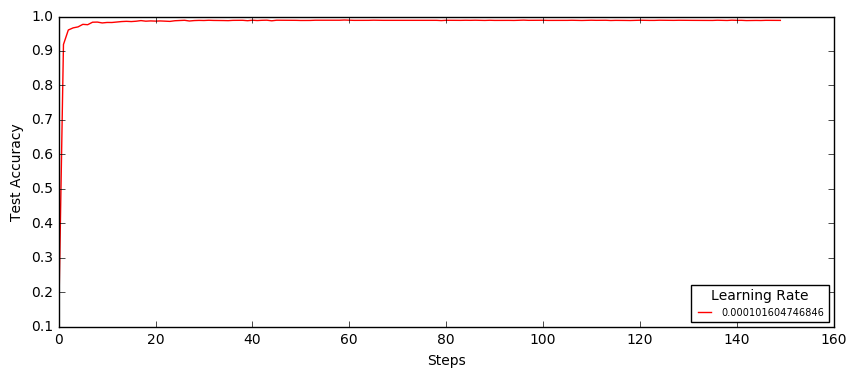

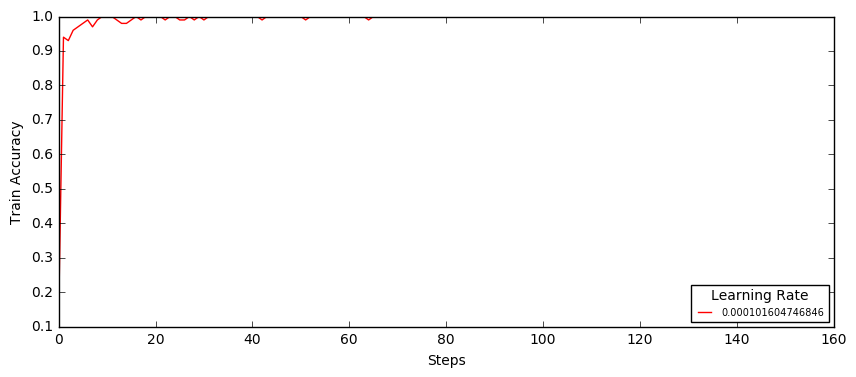

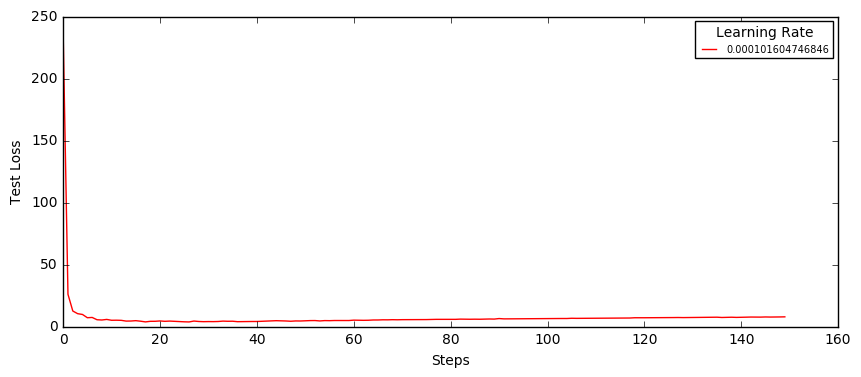

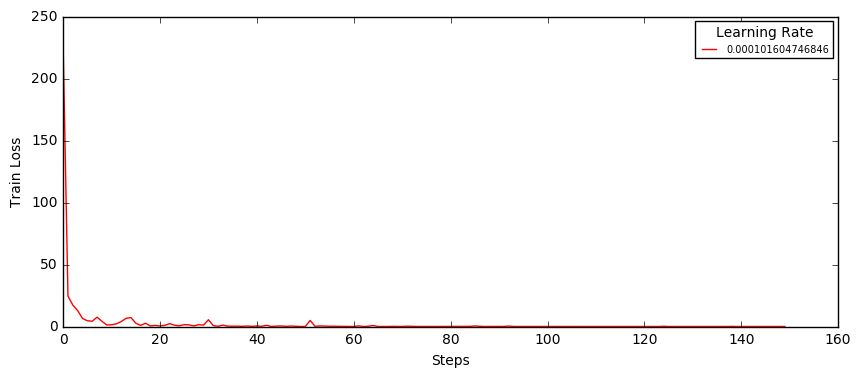

In [7]:
plot_performance(acc_check, learning_rates, train_accuracy, train_loss, test_accuracy, test_loss)

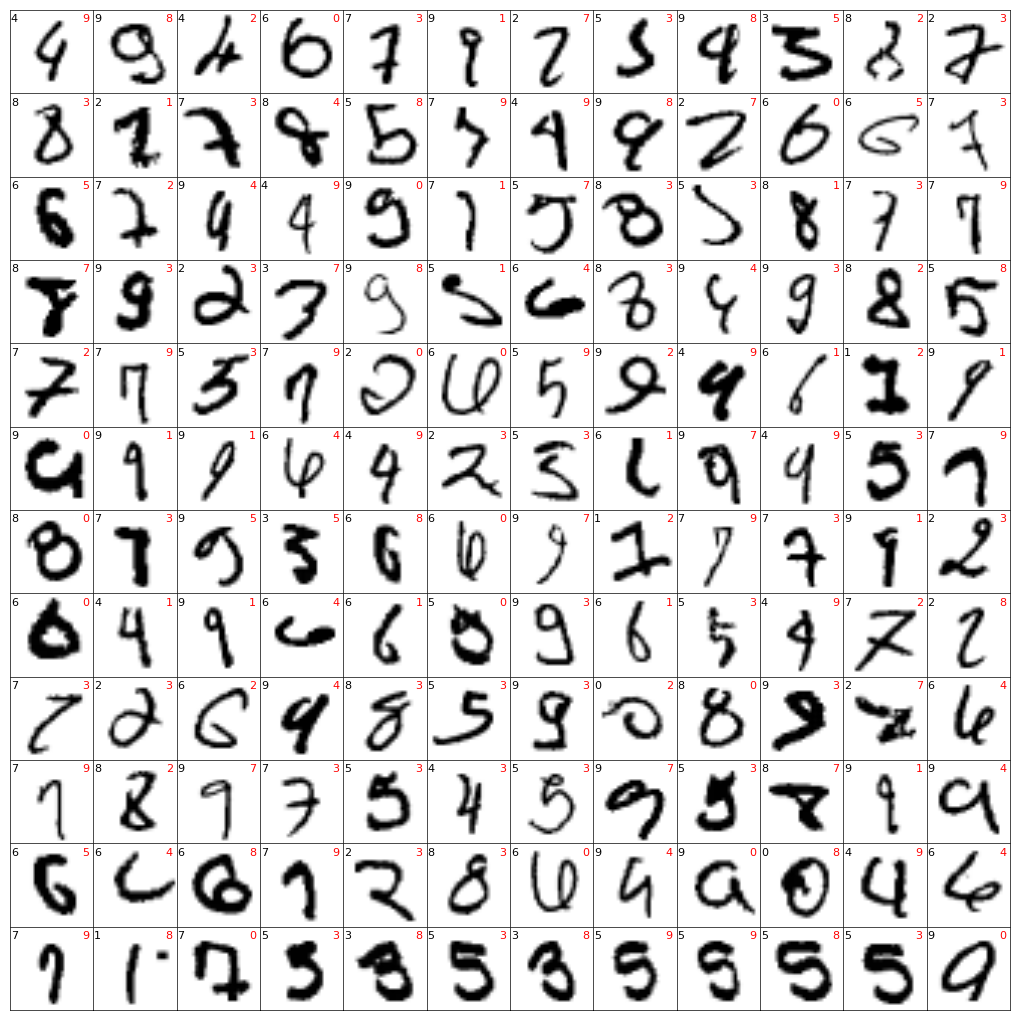

In [7]:
labels = np.argmax(mnist.test.labels, 1)
incorects = np.not_equal(labels, predictions)
plot_batch_images(mnist.test.images[incorects], labels[incorects], predictions[incorects], 144)